# Классификация текстов в российских социальных сетях - задача многоклассовой классификации

Сообщества ВКонтакте могут принадлежать к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно сильное разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве.
На основе заданного набора сообщений определите тему - какой вид спорта обсуждается в выбранном сообществе?

Классификация текстов в российских социальных сетях может быть полезна для широкого круга пользователей, от обычных пользователей до маркетологов, аналитиков и администраторов платформ.

## О наборе данных

| Признак на английском | Перевод на русский |
|---|---|
| VK group id | идентификатор группы во ВКонтакте |
| text | текст сообщения в сообществе |

**Target variable (целевая переменная): category name: athletics, autosport,basketball, boardgames, esport, extreme, football, hockey, martial arts, motosport, tennis, volleyball, winter_sport (название категории: легкая атлетика, автоспорт, баскетбол, настольные игры, киберспорт, экстрим, футбол, хоккей, боевые искусства, мотоспорт, теннис, волейбол, зимний спорт)**

# Mounting a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('russian'))
punctuation_set = set(punctuation)

from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import joblib
# Сохранение лучшей модели по указанному пути
model_path = '/content/drive/MyDrive/Datasets/svm_model.pkl'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the Dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/train_social_media.csv')
data

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


# Exploratory Data Analysis (EDA)

In [ ]:
data.head(10)

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
5,780575952,boardgames,Северные территории на границе королевства Нал...
6,741108447,hockey,Рашит Давыдов поделился деталями общения с гол...
7,642761184,esport,Какой т3 игрок на данный момент перспективнее ...
8,418053478,athletics,7 августа в Москве в Измайловском парке состои...
9,748701390,motosport,Ребята подскажите диску капец или нет Таких тр...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В наборе данных пропусков нет

In [ ]:
data.describe()

,oid
count,3.874000e+04
mean,5.022681e+08
std,2.829376e+08
min,1.659400e+04
25%,2.670941e+08
50%,5.064389e+08
75%,7.423103e+08
max,9.997113e+08


In [ ]:
data.describe(include="object")

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


In [ ]:
data.columns

Index(['oid', 'category', 'text'], dtype='object')

В наборе данных присутствуют дубликаты в столбце text - удалим их

In [ ]:
data = data.drop_duplicates(['text'])
data

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


In [ ]:
data.describe(include="object")

,category,text
count,35774,35774
unique,13,35774
top,autosport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
freq,3015,1


Видим, что все объекты в наборе данных уникальные

 # Data preprocessing


In [ ]:
unique_values = data["category"].unique()
unique_values

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data["category"] = le.fit_transform(data["category"])

In [ ]:
data

,oid,category,text
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,11,Стал известен календарь мужской сборной России...


In [ ]:
data['category'].nunique()

13

<Axes: xlabel='category'>

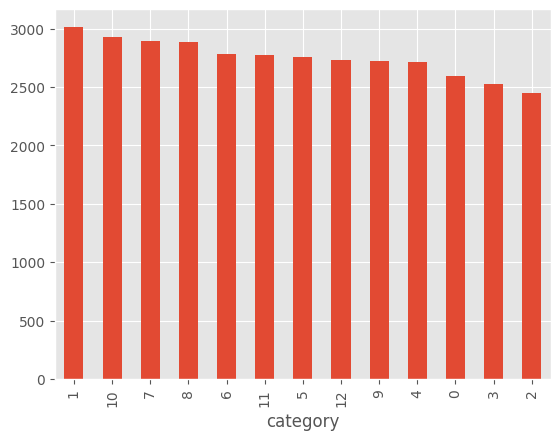

In [ ]:
data['category'].value_counts().plot(kind = 'bar')

Видим, что классы целевой переменной практически сбалансированные

In [ ]:
category_counts = sorted(data['category'].value_counts())
for idx, count in enumerate(category_counts):
    print(f"({idx}) {count}")

(0) 2452
(1) 2524
(2) 2593
(3) 2713
(4) 2720
(5) 2730
(6) 2758
(7) 2773
(8) 2785
(9) 2885
(10) 2897
(11) 2929
(12) 3015


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       35774 non-null  int64 
 1   category  35774 non-null  int64 
 2   text      35774 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## Лемматизация текста

In [ ]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации текста
def lemmatize_text(text):
    tokens = word_tokenize(text)  # Токенизация текста
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Лемматизация токенов
    return ' '.join(lemmatized_tokens)

# Применение лемматизации к столбцу 'text'
data['text_lemmatized'] = data['text'].apply(lemmatize_text)

In [ ]:
data

,oid,category,text,text_lemmatized
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,11,Стал известен календарь мужской сборной России...,Стал известен календарь мужской сборной России...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   oid              35774 non-null  int64 
 1   category         35774 non-null  int64 
 2   text             35774 non-null  object
 3   text_lemmatized  35774 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,oid,category
count,3.577400e+04,35774.000000
mean,5.021517e+08,6.072427
std,2.830081e+08,3.729150
min,1.659400e+04,0.000000
25%,2.667564e+08,3.000000
50%,5.068296e+08,6.000000
75%,7.423103e+08,9.000000
max,9.997113e+08,12.000000


## Удаление стоп-слов и пунктуации из текстов

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words and word not in punctuation_set]
    return filtered_tokens

# Предварительная обработка данных
data['text_lemmatized'] = data['text_lemmatized'].apply(preprocess_text)

In [ ]:

data

,oid,category,text,text_lemmatized
0,365271984,12,Волшебные фото Виктория Поплавская ЕвгенияМедв...,"[волшебные, фото, виктория, поплавская, евгени..."
1,503385563,5,Возвращение в подземелье Треша 33 Эйфория тупо...,"[возвращение, подземелье, треша, 33, эйфория, ..."
2,146016084,6,Лучшие чешские вратари – Доминик Доминатор Гаш...,"[лучшие, чешские, вратари, доминик, доминатор,..."
3,933865449,3,Rtokenoid Warhammer40k валрак решил нас подкор...,"[rtokenoid, warhammer40k, валрак, решил, подко..."
4,713550145,7,Шестеркин затаскивает Рейнджерс в финал Восточ...,"[шестеркин, затаскивает, рейнджерс, финал, вос..."
...,...,...,...,...
38735,910636962,1,8 битная буря снова накрыла пикселями автомоби...,"[8, битная, буря, снова, накрыла, пикселями, а..."
38736,669736851,1,Ира Сидоркова объясняет как сказалась на ее ма...,"[ира, сидоркова, объясняет, сказалась, машине,..."
38737,558919241,10,24 я ракетка мира хорват Марин Чилич обыграл и...,"[24, ракетка, мира, хорват, марин, чилич, обыг..."
38738,776944963,11,Стал известен календарь мужской сборной России...,"[стал, известен, календарь, мужской, сборной, ..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35774 entries, 0 to 38739
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   oid              35774 non-null  int64 
 1   category         35774 non-null  int64 
 2   text             35774 non-null  object
 3   text_lemmatized  35774 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,oid,category
count,3.577400e+04,35774.000000
mean,5.021517e+08,6.072427
std,2.830081e+08,3.729150
min,1.659400e+04,0.000000
25%,2.667564e+08,3.000000
50%,5.068296e+08,6.000000
75%,7.423103e+08,9.000000
max,9.997113e+08,12.000000


# Model Train and Predict

### №1 Функция для подсчета метрик качества модели многоклассовой классификации

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_classification_metrics(y_true, y_pred, y_pred_proba, model_name):
    """
    Функция для подсчета метрик качества модели классификации.

    Аргументы:
    y_true -- истинные значения целевой переменной
    y_pred -- предсказанные значения целевой переменной
    y_pred_proba -- вероятности предсказаний (для бинарной классификации)
    model_name -- название модели

    Возвращает словарь с названиями метрик и их значениями.
    """
    metrics = {'Model': model_name}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision (Micro)'] = precision_score(y_true, y_pred, average='micro')
    metrics['Recall (Micro)'] = recall_score(y_true, y_pred, average='micro')
    metrics['F1 Score (Micro)'] = f1_score(y_true, y_pred, average='micro')
    metrics['Precision (Macro)'] = precision_score(y_true, y_pred, average='macro')
    metrics['Recall (Macro)'] = recall_score(y_true, y_pred, average='macro')
    metrics['F1 Score (Macro)'] = f1_score(y_true, y_pred, average='macro')

    return metrics

### №2 Функция для подбора оптимальных гиперпараметров модели

In [ ]:
from joblib import Parallel, delayed

def find_best_params(X_train, y_train, X_test, y_test, classifier):
    C = [0.1, 0.25, 0.5, 0.75, 1, 2]
    kernel = ["linear", "rbf"]
    gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

    cv = StratifiedKFold(n_splits=10)

    if classifier == "linearsvc":
        svc = LinearSVC(random_state=42)
        param_grid = dict(C=C)
    elif classifier == "nusvc":
        svc = NuSVC(random_state=42)
        param_grid = dict(kernel=kernel, nu=C)
    elif classifier == "svc":
        svc = SVC(random_state=42)
        param_grid = dict(kernel=kernel, C=C, gamma=gamma)
    else:
        print("Invalid classifier")
        return

    grid_svm = GridSearchCV(estimator=svc, cv=cv, param_grid=param_grid, n_jobs=-1)

    with Parallel(n_jobs=-1):
        grid_svm.fit(X_train, y_train)

    #print("best score:", grid_svm.best_score_)
    print("best params:", grid_svm.best_params_)
    #print("test score:", grid_svm.score(X_test, y_test))

    return grid_svm.best_params_

## Токенизация и векторизация текста с использованием Word2Vec

In [ ]:
sentences = data['text_lemmatized']  # Загружаем уже лемматизированные тексты
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

from sklearn.utils import shuffle
def texts_to_vectors(texts):
    vectors = []
    for text in texts:
        vector_sum = 0
        for word in text:
            if word in word2vec_model.wv:
                vector_sum += word2vec_model.wv[word]
        vectors.append(vector_sum)
    return vectors

X = texts_to_vectors(sentences)
y = data['category']

from imblearn.over_sampling import RandomOverSampler
# Создаем объект RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Применяем oversampling к данным для сбалансирования классов
X, y = oversampler.fit_resample(X, y)

# Перемешивание данных
X, y = shuffle(X, y)

# Вывод X и y на экран
print("X (признаки):")
print(X[:5])  # Вывод 5 элементов признаков
print("\n")
print("y (целевая переменная):")
print(y[:5])  # Вывод первых 5 элементов целевой переменной

X (признаки):
[[-10.199378967285156, 10.27782154083252, 11.451620101928711, 0.5757964849472046, -7.448296070098877, -20.334514617919922, 1.3101717233657837, 18.32301902770996, -14.246026992797852, -8.810309410095215, -2.061013698577881, -24.194156646728516, -3.825838327407837, 3.0165798664093018, 5.548562049865723, -8.141133308410645, 10.176650047302246, -12.553651809692383, -1.7184607982635498, -17.63494110107422, 8.055116653442383, 5.200676918029785, 20.43402862548828, -11.975690841674805, -1.1343547105789185, 9.121942520141602, -2.4999301433563232, -5.34096097946167, -13.950915336608887, 1.0144858360290527, 9.750832557678223, 2.595280885696411, 3.0892508029937744, -15.282814979553223, -2.8316402435302734, 4.277851104736328, 9.436882019042969, -5.419778823852539, -11.831777572631836, -14.00029182434082, 8.99056339263916, -10.647775650024414, -9.31680679321289, -0.661114513874054, 6.879426002502441, 3.3637170791625977, -5.5441107749938965, -0.3404286801815033, 0.33203211426734924, -4.

<Axes: xlabel='category'>

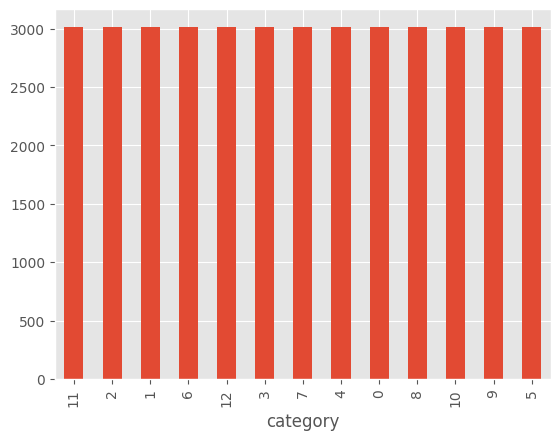

In [ ]:
y.value_counts().plot(kind = 'bar')

Видим, что теперь классы целевой переменной полностью сбалансированные

## Разбиение на контроль и масштабирование данных

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Построение модели многоклассовой классификации: SVC (Supported Vector Machine) - Машина опорных векторов

## Модель №1 - Класс SVM

### Подбор оптимальных гиперпараметров модели

In [ ]:
best_params = find_best_params(X_train, y_train, X_test, y_test, "svc")

best params: {'C': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
svm = SVC(random_state=42, probability=True, **best_params)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

In [ ]:
metrics_1 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass SVM №1')
print("Метрики качества модели:")
for metric, value in metrics_1.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass SVM №1
Accuracy: 0.5750733511927542
Precision (Micro): 0.5750733511927542
Recall (Micro): 0.5750733511927542
F1 Score (Micro): 0.5750733511927542
Precision (Macro): 0.6235408708176255
Recall (Macro): 0.574548203173759
F1 Score (Macro): 0.5881511770618126


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       614
           1       0.73      0.63      0.67       606
           2       0.61      0.50      0.55       605
           3       0.85      0.69      0.76       600
           4       0.31      0.61      0.41       604
           5       0.35      0.56      0.43       582
           6       0.34      0.43      0.38       602
           7       0.60      0.49      0.54       590
           8       0.69      0.50      0.58       601
           9       0.72      0.64      0.68       584
          10       0.87      0.81      0.84       623
          11       0.66      0.50      0.57       616
          12       0.55      0.43      0.48       612

    accuracy                           0.58      7839
   macro avg       0.62      0.57      0.59      7839
weighted avg       0.62      0.58      0.59      7839



### Модель №2 - Класс NuSVC

### Подбор оптимальных гиперпараметров модели

In [ ]:
best_params = find_best_params(X_train, y_train, X_test, y_test, "nusvc")

best params: {'kernel': 'linear', 'nu': 0.25}


In [ ]:
nu_svm = NuSVC(random_state=42, probability=True, **best_params)
nu_svm.fit(X_train, y_train)
y_pred = nu_svm.predict(X_test)
y_pred_proba = nu_svm.decision_function(X_test)

In [ ]:
metrics_2 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass SVM №2')
print("Метрики качества модели:")
for metric, value in metrics_2.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass SVM №2
Accuracy: 0.5059318790662074
Precision (Micro): 0.5059318790662074
Recall (Micro): 0.5059318790662074
F1 Score (Micro): 0.5059318790662074
Precision (Macro): 0.5237164708229584
Recall (Macro): 0.5050778996865769
F1 Score (Macro): 0.4988782297902106


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       614
           1       0.51      0.62      0.56       606
           2       0.42      0.53      0.47       605
           3       0.70      0.74      0.72       600
           4       0.32      0.36      0.34       604
           5       0.25      0.46      0.32       582
           6       0.40      0.09      0.14       602
           7       0.32      0.35      0.34       590
           8       0.56      0.44      0.49       601
           9       0.67      0.65      0.66       584
          10       0.84      0.80      0.82       623
          11       0.49      0.52      0.50       616
          12       0.55      0.28      0.37       612

    accuracy                           0.51      7839
   macro avg       0.52      0.51      0.50      7839
weighted avg       0.53      0.51      0.50      7839



### Модель №3 - Класс LinearSVC

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

### Подбор оптимальных гиперпараметров модели

In [ ]:
best_params = find_best_params(X_train, y_train, X_test, y_test, "linearsvc")

best params: {'C': 2}


In [ ]:
linear_svm = LinearSVC(random_state=42, **best_params)
calibrated_svc = CalibratedClassifierCV(linear_svm, method='sigmoid')
calibrated_svc.fit(X_train, y_train)
y_pred = calibrated_svc.predict(X_test)
y_pred_proba = calibrated_svc.predict_proba(X_test)

In [ ]:
metrics_3 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass SVM №3')
print("Метрики качества модели:")
for metric, value in metrics_3.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass SVM №3
Accuracy: 0.539609644087256
Precision (Micro): 0.539609644087256
Recall (Micro): 0.539609644087256
F1 Score (Micro): 0.539609644087256
Precision (Macro): 0.5738203337892318
Recall (Macro): 0.5389785025796191
F1 Score (Macro): 0.5417399146144755


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.84      0.60      0.70       614
           1       0.64      0.57      0.61       606
           2       0.49      0.55      0.52       605
           3       0.82      0.67      0.74       600
           4       0.34      0.63      0.44       604
           5       0.30      0.47      0.37       582
           6       0.53      0.18      0.27       602
           7       0.42      0.47      0.45       590
           8       0.51      0.51      0.51       601
           9       0.63      0.65      0.64       584
          10       0.86      0.81      0.84       623
          11       0.55      0.51      0.53       616
          12       0.52      0.38      0.44       612

    accuracy                           0.54      7839
   macro avg       0.57      0.54      0.54      7839
weighted avg       0.58      0.54      0.54      7839



# Model Evaluation

In [ ]:
model_metrics_1_filtered = {key: value for key, value in metrics_1.items() if ((key != 'Model'))}

model_metrics_2_filtered = {key: value for key, value in metrics_2.items() if ((key != 'Model'))}

model_metrics_3_filtered = {key: value for key, value in metrics_3.items() if ((key != 'Model'))}

# Создание DataFrame
df = pd.DataFrame({
    "Model SVM №1": model_metrics_1_filtered,
    "Model SVM №2": model_metrics_2_filtered,
    "Model SVM №3": model_metrics_3_filtered
})

# Функция для форматирования значений
def format_values(value):
    if isinstance(value, float):
        return "{:.8f}".format(value)
    else:
        return value

# Применение функции к каждому элементу DataFrame
df = df.applymap(format_values)

# Вывод DataFrame как красивой таблицы
display(df)

,Model SVM №1,Model SVM №2,Model SVM №3
Accuracy,0.57507335,0.50593188,0.53960964
Precision (Micro),0.57507335,0.50593188,0.53960964
Recall (Micro),0.57507335,0.50593188,0.53960964
F1 Score (Micro),0.57507335,0.50593188,0.53960964
Precision (Macro),0.62354087,0.52371647,0.57382033
Recall (Macro),0.57454820,0.50507790,0.53897850
F1 Score (Macro),0.58815118,0.49887823,0.54173991


## Вывод: по метрикам качества лучшей моделью оказалась модель №1 - модель многоклассовой классификации (SVC (Supported Vector Machine) - Машина опорных векторов) с подбором лучших значений гиперпараметров и использованием класса SVM

# Визуализация метрик качества

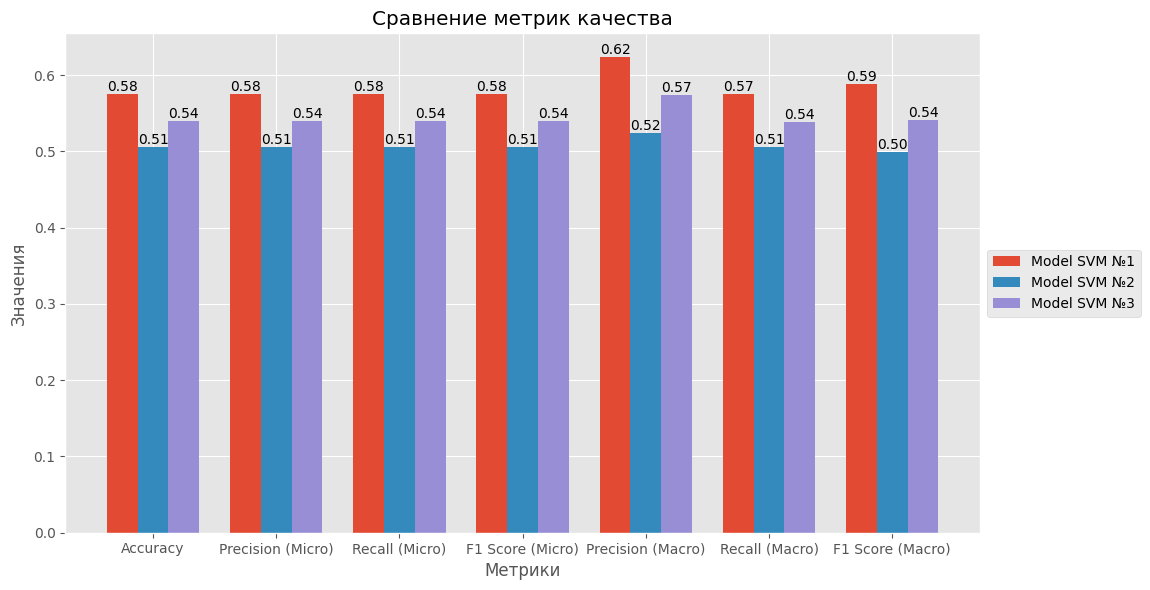

In [ ]:
# Извлечение метрик из словарей
metrics_names = list(model_metrics_1_filtered.keys())
metrics_values_1 = list(model_metrics_1_filtered.values())
metrics_values_2 = list(model_metrics_2_filtered.values())
metrics_values_3 = list(model_metrics_3_filtered.values())

# Создание подписей для столбцов
model_names = ["Model SVM №1", "Model SVM №2", "Model SVM №3"]

# Создание подписей для оси X (метрик)
x = range(len(metrics_names))

# Ширина столбцов
bar_width = 0.25

# Создание графика
plt.figure(figsize=(10, 6))

# Построение столбчатых диаграмм для каждой метрики
for i, (metric_name, metric_value) in enumerate(zip(metrics_names, [metrics_values_1, metrics_values_2, metrics_values_3])):
    plt.bar([pos + i * bar_width for pos in x], metric_value, width=bar_width, label=model_names[i])
    # Добавление подписей значений метрик сверху
    for j, value in enumerate(metric_value):
        plt.text(j + i * bar_width, value, f'{value:.2f}', ha='center', va='bottom')

# Добавление подписей к осям и заголовка
plt.xlabel('Метрики')
plt.ylabel('Значения')
plt.title('Сравнение метрик качества')
plt.xticks([pos + bar_width for pos in x], metrics_names)

# Отображение графика
plt.tight_layout()

# Отдельное размещение легенды
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Нативная реализация метода RobustScaler() в виде функции

$$scaled\_data = \frac{data - median(data)}{IQR(data)}$$$$$$

In [ ]:
import numpy as np

def custom_robust_scaler(data):
    """
    Реализация метода RobustScaler для масштабирования данных.

    Аргументы:
    data: numpy.array или pandas.Series, данные для масштабирования

    Возвращает:
    scaled_data: numpy.array, масштабированные данные
    """
    median = np.median(data)
    quartile_1 = np.percentile(data, 25)
    quartile_3 = np.percentile(data, 75)
    IQR = quartile_3 - quartile_1

    scaled_data = (data - median) / IQR
    return scaled_data

# Генерируем рандомные данные
np.random.seed(42)
random_data = np.random.randint(0, 100, size=10)

# Применяем нашу нативную реализацию RobustScaler
scaled_data = custom_robust_scaler(random_data)

# Выводим результаты
print("Исходные данные:", random_data)
print("-----------------------------------------------------------------------------------")
print("Масштабированные данные:", scaled_data, np.median(scaled_data), np.percentile(scaled_data, 25), np.percentile(scaled_data, 75), np.percentile(scaled_data, 75) - np.percentile(scaled_data, 25))

Исходные данные: [51 92 14 71 60 20 82 86 74 74]
-----------------------------------------------------------------------------------
Масштабированные данные: [-0.80373832  0.72897196 -2.18691589 -0.05607477 -0.46728972 -1.96261682
  0.35514019  0.5046729   0.05607477  0.05607477] 0.0 -0.719626168224299 0.2803738317757009 1.0
